# 0.0 IMPORTS

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import inflection
import math

from IPython.display import Image
from datetime import datetime, timedelta

## 0.1 HELPER FUNCTIONS

In [2]:
# Set figure size for plottiing
plt.rcParams['figure.figsize'] = [20, 12]

# Set seaborn plot style
sns.set(style='dark')

## 0.2 LOADING DATA

In [3]:
# Loading initial data
df_sales_raw = pd.read_csv('data/train.csv', low_memory=False)
df_store_raw = pd.read_csv('data/store.csv', low_memory=False)

# Merging DataFrames to get sales and store attributes
df_raw = pd.merge(df_sales_raw, df_store_raw, how='left', on='Store')
df_raw.head(5)

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
0,1,5,2015-07-31,5263,555,1,1,0,1,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN
1,2,5,2015-07-31,6064,625,1,1,0,1,a,a,570.0,11.0,2007.0,1,13.0,2010.0,"Jan,Apr,Jul,Oct"
2,3,5,2015-07-31,8314,821,1,1,0,1,a,a,14130.0,12.0,2006.0,1,14.0,2011.0,"Jan,Apr,Jul,Oct"
3,4,5,2015-07-31,13995,1498,1,1,0,1,c,c,620.0,9.0,2009.0,0,NaN,NaN,NaN
4,5,5,2015-07-31,4822,559,1,1,0,1,a,a,29910.0,4.0,2015.0,0,NaN,NaN,NaN


# 1.0 DATA DESCRIPTION

## 1.1 Rename Columns

In [4]:
# Creating copy to manipulate DataFrame on this section
df1 = df_raw.copy()

# Saving the original column names in a list
cols_original = df1.columns.to_list()

# Defining local function to turn names into snakecase
snakecase = lambda x: inflection.underscore(x)

# Applying function to all names and saving into a new variable
cols_new_name = list(map(snakecase, cols_original))

# Renaming columns
df1.columns = cols_new_name

df1.columns

Index(['store', 'day_of_week', 'date', 'sales', 'customers', 'open', 'promo',
       'state_holiday', 'school_holiday', 'store_type', 'assortment',
       'competition_distance', 'competition_open_since_month',
       'competition_open_since_year', 'promo2', 'promo2_since_week',
       'promo2_since_year', 'promo_interval'],
      dtype='object')

## 1.2 Data Dimensions

In [5]:
print(f'The DataFrame have {df1.shape[0]} rows')

print(f'The DataFrame have {df1.shape[1]} columns')

The DataFrame have 1017209 rows
The DataFrame have 18 columns


## 1.3 Data Types

In [6]:
# Cast date column into date format
df1['date'] = pd.to_datetime(df1['date'])

df1.dtypes

store                                    int64
day_of_week                              int64
date                            datetime64[ns]
sales                                    int64
customers                                int64
open                                     int64
promo                                    int64
state_holiday                           object
school_holiday                           int64
store_type                              object
assortment                              object
competition_distance                   float64
competition_open_since_month           float64
competition_open_since_year            float64
promo2                                   int64
promo2_since_week                      float64
promo2_since_year                      float64
promo_interval                          object
dtype: object

## 1.4 Check NA

In [7]:
# Check if a field is null and sums columns nulls
df1.isna().sum()

store                                0
day_of_week                          0
date                                 0
sales                                0
customers                            0
open                                 0
promo                                0
state_holiday                        0
school_holiday                       0
store_type                           0
assortment                           0
competition_distance              2642
competition_open_since_month    323348
competition_open_since_year     323348
promo2                               0
promo2_since_week               508031
promo2_since_year               508031
promo_interval                  508031
dtype: int64

## 1.5 Fillout NAs

In [8]:
# competition_distance
max_distance = 200000
df1['competition_distance'] = df1['competition_distance'].apply(lambda x: max_distance if math.isnan(x) else x)

# competition_open_since_month 
df1['competition_open_since_month'] = df1.apply(lambda x: x['date'].month if math.isnan(x['competition_open_since_month']) else x['competition_open_since_month'], axis=1)                                                       

# competition_open_since_year
df1['competition_open_since_year'] = df1.apply(lambda x: x['date'].year if math.isnan(x['competition_open_since_year']) else x['competition_open_since_year'], axis=1) 

# promo2_since_week
df1['promo2_since_week'] = df1.apply(lambda x: x['date'].week if math.isnan(x['promo2_since_week']) else x['promo2_since_week'], axis=1)                                                       

# promo2_since_year
df1['promo2_since_year'] = df1.apply(lambda x: x['date'].year if math.isnan(x['promo2_since_year']) else x['promo2_since_year'], axis=1)                                                       

# promo_interval
month_map = {1:'Jan', 2:'Feb', 3:'Mar' , 4:'Apr' , 5:'May' , 6:'Jun' , 7:'Jul' , 8:'Aug' , 9:'Sept' , 10:'Oct' , 11:'Nov' , 12:'Dec'}

# Fill the NA's with 0
df1['promo_interval'].fillna(0, inplace=True)

# Create a column with the month date written
df1['month_map'] = df1['date'].dt.month.map(month_map)

# Flag is there's promo currently active compared with date
df1['is_promo'] = df1[['month_map', 'promo_interval']].apply(lambda x: 0 if x['promo_interval'] == 0 else 1 if x['month_map'] in x['promo_interval'].split(',') else 0, axis=1)

In [9]:
# Recheck of NA's
df1.isna().sum()

store                           0
day_of_week                     0
date                            0
sales                           0
customers                       0
open                            0
promo                           0
state_holiday                   0
school_holiday                  0
store_type                      0
assortment                      0
competition_distance            0
competition_open_since_month    0
competition_open_since_year     0
promo2                          0
promo2_since_week               0
promo2_since_year               0
promo_interval                  0
month_map                       0
is_promo                        0
dtype: int64

## 1.6 Checking Data Types

In [10]:
# competition_open_since_month           
df1['competition_open_since_month'] = df1['competition_open_since_month'].astype('int64')

# competition_open_since_year
df1['competition_open_since_year'] = df1['competition_open_since_year'].astype('int64')

# promo2_since_week
df1['promo2_since_week'] = df1['promo2_since_week'].astype('int64')

# promo2_since_year
df1['promo2_since_year'] = df1['promo2_since_year'].astype('int64')

## 1.7 Descriptive Statistics

In [11]:
num_attributes = df1.select_dtypes(include=['int64', 'float64'])
cat_attributes = df1.select_dtypes(exclude=['int64', 'float64', 'datetime64[ns]'])

### 1.7.1 Numerical Attributes

In [12]:
# Central Tendencies - mean, median
ct1 = pd.DataFrame(num_attributes.apply(np.mean)).T
ct2 = pd.DataFrame(num_attributes.apply(np.median)).T

# Dispersion - std, min, max, range, skew, kurtosis
d1 = pd.DataFrame(num_attributes.apply(np.std)).T
d2 = pd.DataFrame(num_attributes.apply(np.min)).T
d3 = pd.DataFrame(num_attributes.apply(np.max)).T
d4 = pd.DataFrame(num_attributes.apply(lambda x: np.max(x) - np.min(x))).T
d5 = pd.DataFrame(num_attributes.apply(lambda x: x.skew())).T
d6 = pd.DataFrame(num_attributes.apply(lambda x: x.kurtosis())).T

statistical_metrics = pd.concat([d2, d3, d4, ct1, ct2, d1, d5, d6]).T.reset_index()
statistical_metrics.columns = ['attibutes', 'min', 'max', 'range', 'mean', 'median', 'std', 'skew', 'kurtosis']

statistical_metrics

,attibutes,min,max,range,mean,median,std,skew,kurtosis
0,store,1.0,1115.0,1114.0,558.429727,558.0,321.908493,-0.000955,-1.200524
1,day_of_week,1.0,7.0,6.0,3.998341,4.0,1.997390,0.001593,-1.246873
2,sales,0.0,41551.0,41551.0,5773.818972,5744.0,3849.924283,0.641460,1.778375
3,customers,0.0,7388.0,7388.0,633.145946,609.0,464.411506,1.598650,7.091773
4,open,0.0,1.0,1.0,0.830107,1.0,0.375539,-1.758045,1.090723
5,promo,0.0,1.0,1.0,0.381515,0.0,0.485758,0.487838,-1.762018
6,school_holiday,0.0,1.0,1.0,0.178647,0.0,0.383056,1.677842,0.815154
7,competition_distance,20.0,200000.0,199980.0,5935.442677,2330.0,12547.646829,10.242344,147.789712
8,competition_open_since_month,1.0,12.0,11.0,6.786849,7.0,3.311085,-0.042076,-1.232607
9,competition_open_since_year,1900.0,2015.0,115.0,2010.324840,2012.0,5.515591,-7.235657,124.071304


### 1.7.2 Categorical Attributes

In [13]:
# Check unique values of each category
cat_attributes.apply(lambda x: x.unique().shape[0])

state_holiday      4
store_type         4
assortment         3
promo_interval     4
month_map         12
dtype: int64

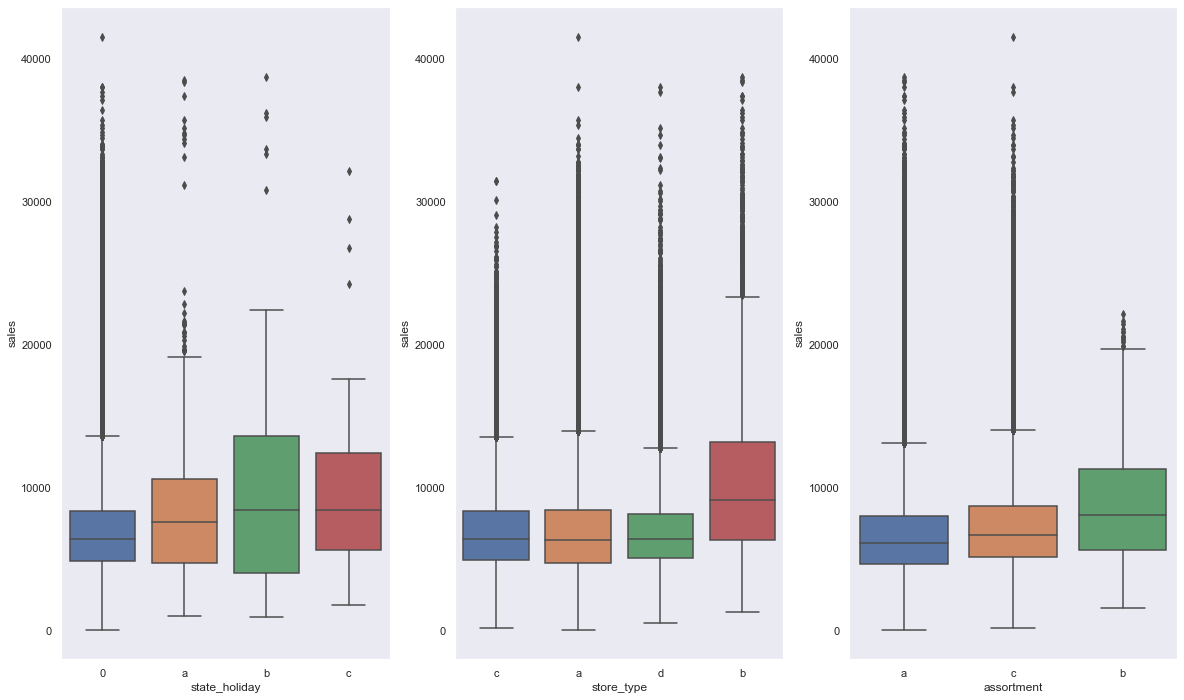

In [14]:
# Boxplot of categorical attributes

plt.figure(figsize=(20,12))

aux1 = df1[((df1['sales'] > 0) & (df1['state_holiday'] != 0 ))]

ax1 = plt.subplot(1, 3, 1)
g1 = sns.boxplot(data=aux1, x='state_holiday', y='sales', ax=ax1)

ax2 = plt.subplot(1, 3, 2)
g2 = sns.boxplot(data=aux1, x='store_type', y='sales', ax=ax2)

ax3 = plt.subplot(1, 3, 3)
g3 = sns.boxplot(data=aux1, x='assortment', y='sales', ax=ax3)

# 2.0 FEATURE ENGINEERING

In [15]:
df2 = df1.copy()

## 2.1 Hypothesis Mindmap

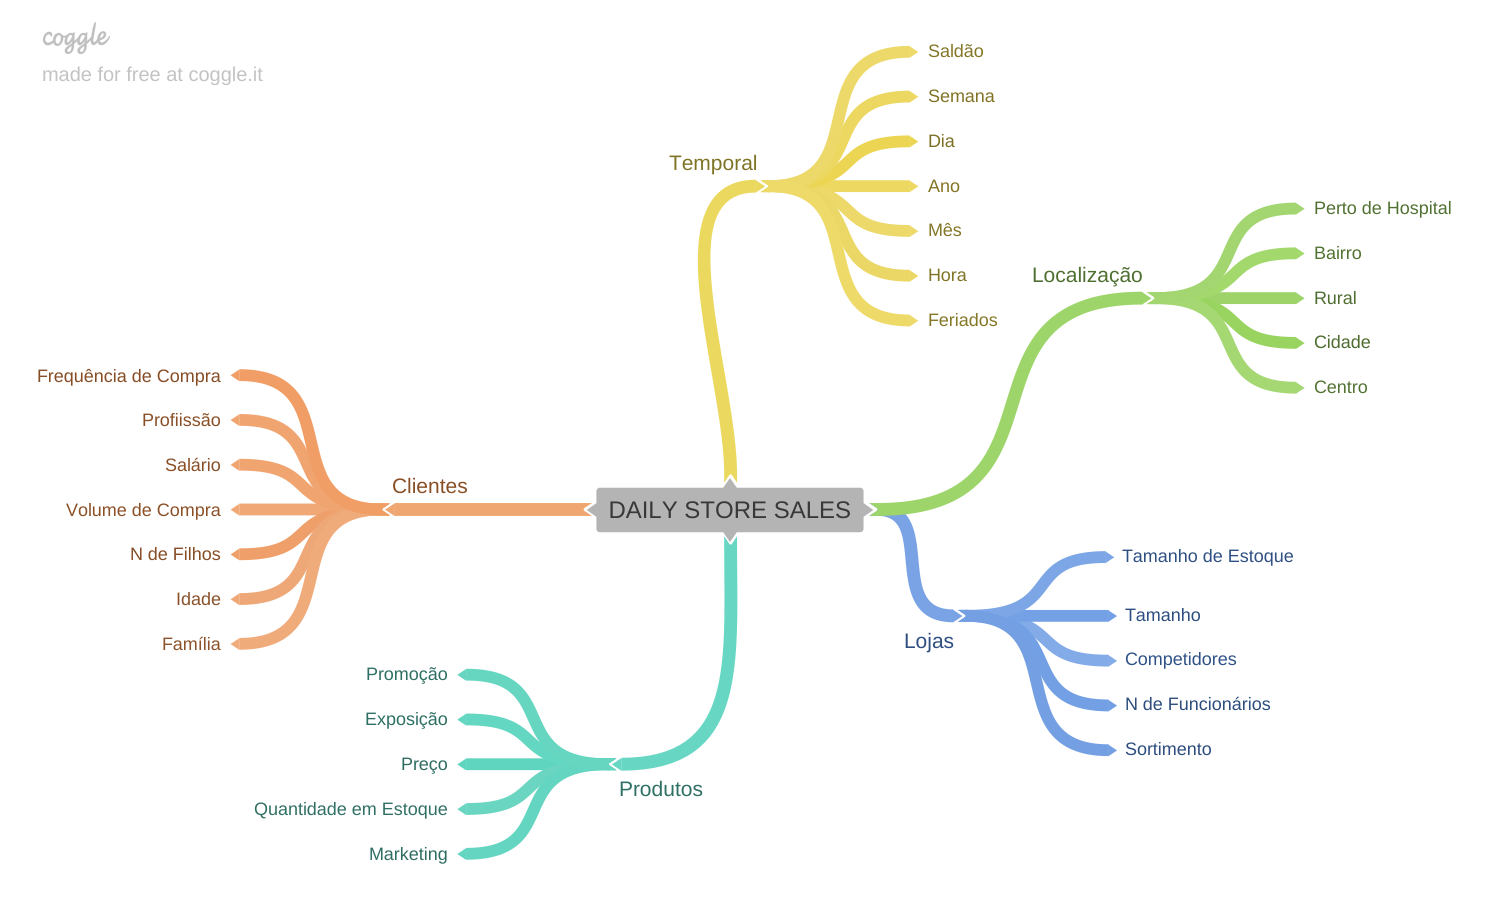

In [16]:
Image('img/mindmap_hypothesis.png')

## 2.2 Creating Hypothesis

### 2.2.1 Store Hypothesis

**1.** Stores with more employees should sell more.  
**2.** Stores with more stock capacity should sell more.  
**3.** Larger stores should sell more.  
**4.** Stores with a larger assortment should sell more.  
**5.** Stores with closer competitors should sell less.  
**6.** Stores with longer-term competitors should sell more.  

### 2.2.2 Product Hypothesis

**1.** Stores that invest more in marketing should sell more.  
**2.** Stores with more product exposure should sell more.  
**3.** Stores with lower priced products should sell more.  
**5.** Stores with more aggressive promotions (larger discounts) should sell more.  
**6.** Stores with longer promotions should sell more.  
**7.** Stores with more promotion days should sell more.  
**8.** Stores with more consecutive promotions should sell more.  

### 2.2.3 Time Hypothesis

**1.** stores open during the Christmas holiday should sell more.  
**2.** Stores should sell more over the years.  
**3.** Stores should sell more in the second half of the year.  
**4.** Stores should sell more after the 10th of each month.  
**5.** Stores should sell less on weekends.  
**6.** Stores should sell less during school holidays.

## 2.3 Hypothesis List (prioritized)

**1.** Stores with a larger assortment should sell more.  
**2.** Stores with closer competitors should sell less.  
**3.** Stores with longer-term competitors should sell more.  
**4.** Stores with longer promotions should sell more.  
**5.** Stores with more promotion days should sell more.  
**6.** Stores with more consecutive promotions should sell more.  
**7.** stores open during the Christmas holiday should sell more.  
**8.** Stores should sell more over the years.  
**9.** Stores should sell more in the second half of the year.  
**10.** Stores should sell more after the 10th of each month.  
**11.** Stores should sell less on weekends.  
**12.** Stores should sell less during school holidays.

## 2.4 Feature Engineering

In [17]:
df2.columns

Index(['store', 'day_of_week', 'date', 'sales', 'customers', 'open', 'promo',
       'state_holiday', 'school_holiday', 'store_type', 'assortment',
       'competition_distance', 'competition_open_since_month',
       'competition_open_since_year', 'promo2', 'promo2_since_week',
       'promo2_since_year', 'promo_interval', 'month_map', 'is_promo'],
      dtype='object')

In [18]:
# year
df2['year'] = df2['date'].dt.year

# month
df2['month'] = df2['date'].dt.month

# day
df2['day'] = df2['date'].dt.day

# week of the year
df2['week_of_year'] = df2['date'].dt.isocalendar().week

# year week
df2['year_week'] = df2['date'].dt.strftime('%Y-%W')

# Competition since (Number of months from the date since the store have competition)
df2['competition_since'] = df2.apply(lambda x: datetime(year=x['competition_open_since_year'], month=x['competition_open_since_month'], day=1), axis=1)
df2['competition_time_month'] = ((df2['date'] - df2['competition_since']) / 30).apply(lambda x: x.days).astype('int64') # Granularity in monhts

# Promo since (Number of weeks from date since there is a promo active)
df2['promo_since'] = (df2['promo2_since_year'].astype('str') + '-' + df2['promo2_since_week'].astype('str'))
df2['promo_since'] = df2['promo_since'].apply(lambda x: datetime.strptime(x +'-1', '%Y-%W-%w') - timedelta(days=7))
df2['promo_time_week'] = ((df2['date'] - df2['promo_since']) / 7).apply(lambda x: x.days).astype('int64')

# Assortment
df2['assortment'] = df2['assortment'].apply(lambda x: 'basic' if x == 'a' else 
                                                      'extra' if x == 'b' else 
                                                      'extended')

# State Holiday
# a = public holiday, b = Easter holiday, c = Christmas, 0 = None
df2['state_holiday'] = df2['state_holiday'].apply(lambda x: 'public_holiday' if x == 'a' else 
                                                            'easter_holiday' if x == 'b' else 
                                                            'christmas' if x == 'c' else 
                                                            'regular_day')

# 3.0 FEATURE FILTERING

In [19]:
df3 = df2.copy()

### 3.1 Rows

In [20]:
print(f'Rows before filtering: {df3.shape[0]}')

Rows before filtering: 1017209


In [21]:
df3 = df3[(df3['open'] != 0) & (df3['sales'] > 0)].reset_index()
print(f'Rows after filtering: {df3.shape[0]}')

Rows after filtering: 844338


### 3.2 Columns

In [22]:
df3.drop(columns=['index', 'customers', 'open', 'promo_interval', 'month_map'], inplace=True)

# 4.0 EXPLORATORY DATA ANALYSIS

In [23]:
df4 = df3.copy()

## 4.1 Univariate

### 4.1.1 Response Variable

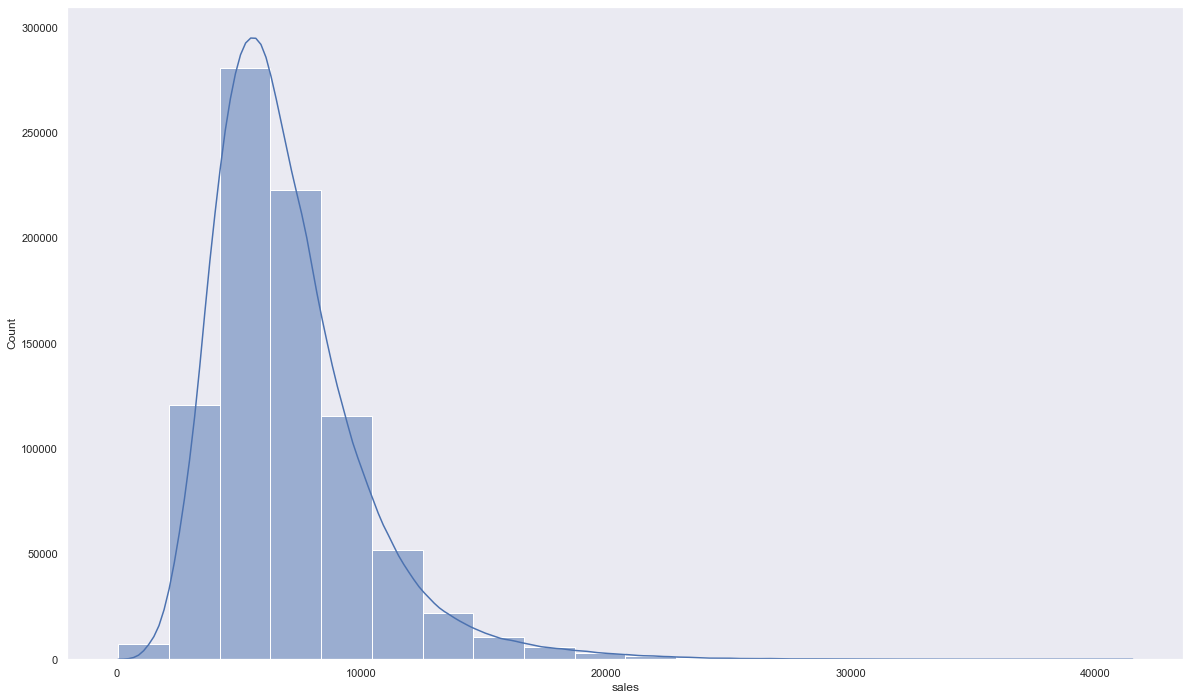

In [24]:
# Set histogram of sales
sns.histplot(data=df4, x='sales', bins=20, kde=True);

### 4.1.2 Numeric Variables

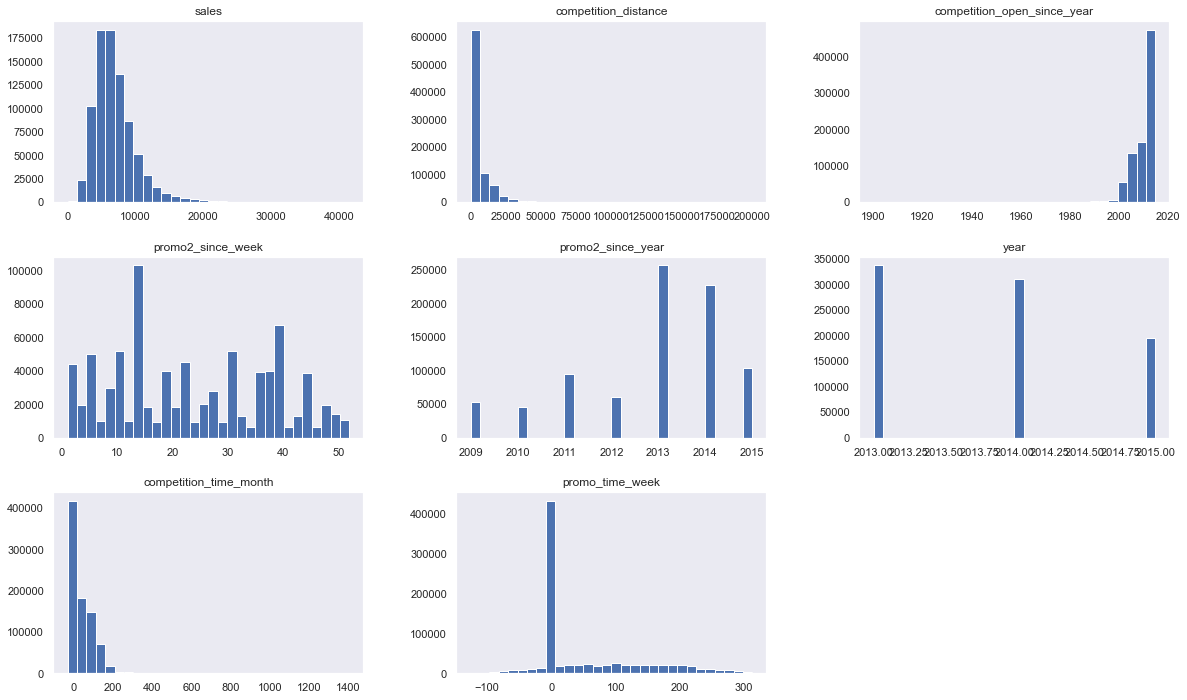

In [25]:
# Filter only numeric features
num_attributes = df4.select_dtypes(include=['int64', 'float64'])

# Excluding some features that does not make sense
cols = ['store', 'day_of_week', 'promo', 'school_holiday', 'promo2', 'is_promo', 'competition_open_since_month', 'month', 'day']
num_attributes.drop(columns=cols, inplace=True)

# Create histograms for all numeric variables
num_attributes.hist(bins=30, grid=False);

### 4.1.3 categorical Variable

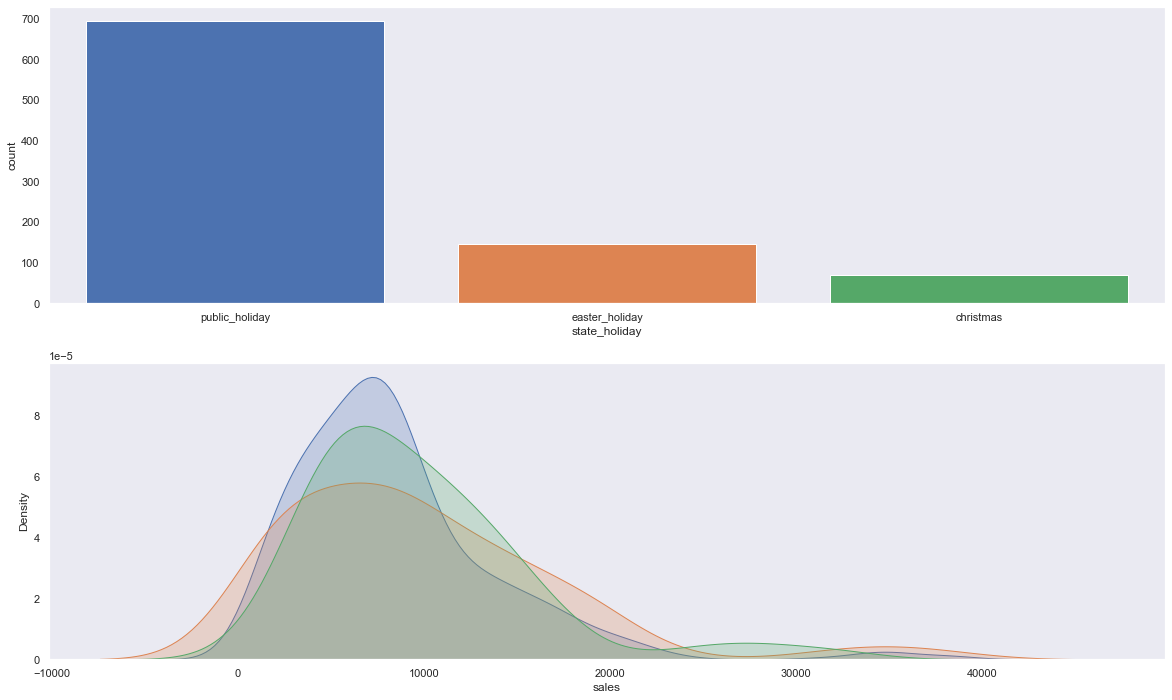

In [26]:
# Filter all categorical attributes
cat_attributes = df4.select_dtypes(include='object')

# first plot - count plot of state holidays
plt.subplot(2, 1, 1)
aux2 = cat_attributes[cat_attributes['state_holiday'] != 'regular_day']
sns.countplot(data=aux2, x='state_holiday', saturation=1)

# second plot, distribution of each state holiday category
plt.subplot(2, 1, 2)
sns.kdeplot(df4[cat_attributes['state_holiday'] == 'public_holiday']['sales'], shade=True)
sns.kdeplot(df4[cat_attributes['state_holiday'] == 'easter_holiday']['sales'], shade=True)
sns.kdeplot(df4[cat_attributes['state_holiday'] == 'christmas']['sales'], shade=True);

## 4.2 Bivariate - Hypothesis Validation

#### **H1.** Stores with a larger assortment should sell more.
**FALSE**. Stores with basic and extended assortments represents a huge sales volume, and extra represents a small volume.

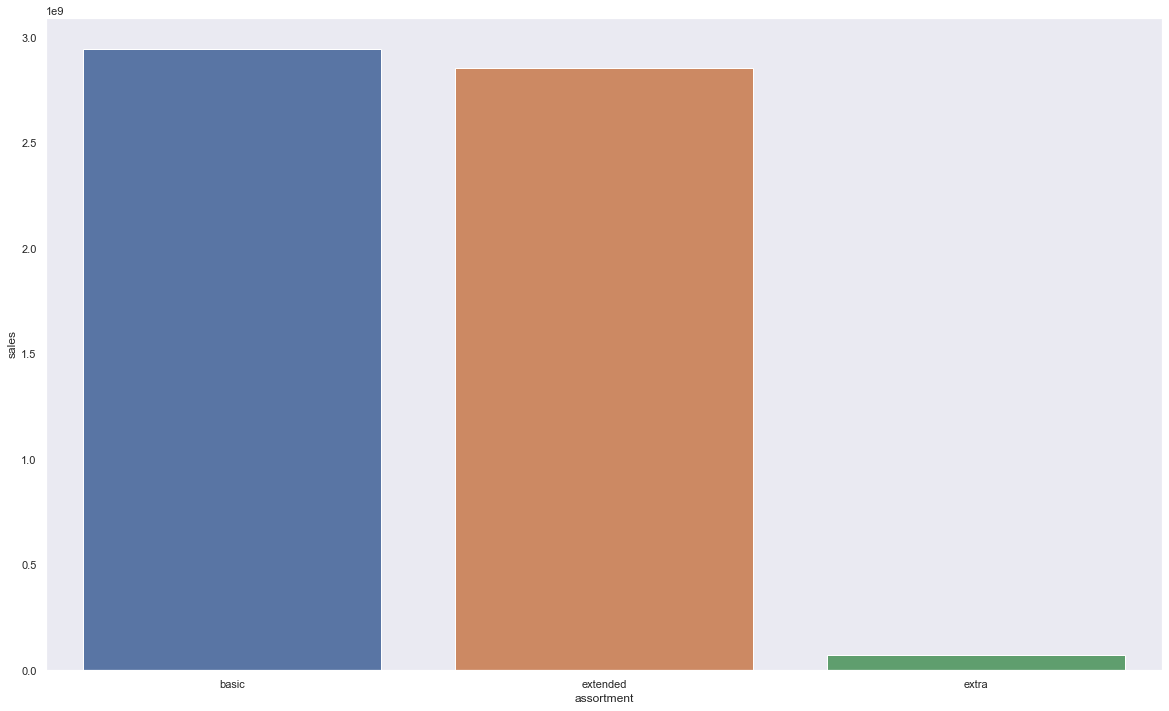

In [27]:
# barplot of sales volume per assortment type
aux1 = df4[['assortment', 'sales']].groupby('assortment').sum().reset_index()
sns.barplot(data=aux1, x='assortment', y='sales');

#### **H2.** Do the behave of assortment on sales changed overtime?
**FALSE**. The behavior was always pretty the same

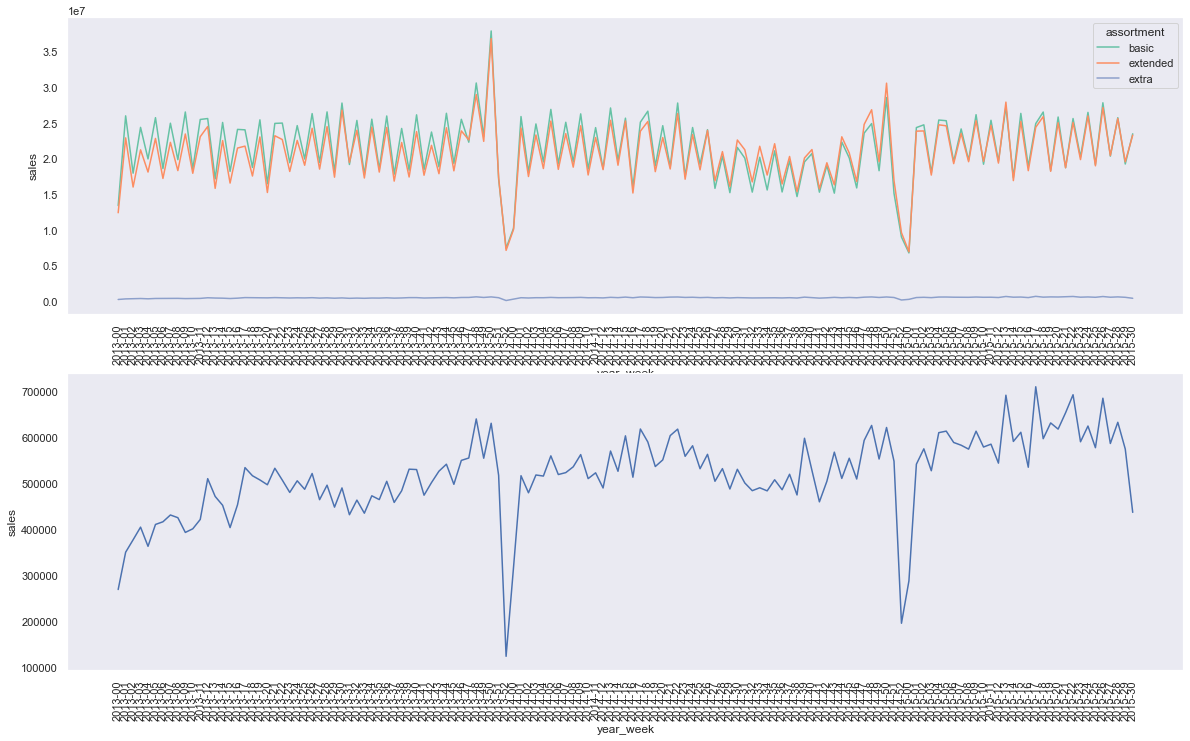

In [28]:
plt.figure(figsize=(20, 12))

# sales volumes per assortment type over the weeks
plt.subplot(2, 1, 1)
aux2 = df4[['assortment', 'sales', 'year_week']].groupby(['year_week', 'assortment']).sum().reset_index()
ax1 = sns.lineplot(data=aux2, x='year_week', y='sales', hue='assortment', palette='Set2')
plt.xticks(rotation=90)

# sales volumes of extra assortment type
plt.subplot(2, 1, 2)
aux3 = aux2[aux2['assortment'] == 'extra']
ax2 = sns.lineplot(data=aux3, x='year_week', y='sales', palette='Set2')
plt.xticks(rotation=90);

#### H3. Stores with closer competitors should sell less.
**FALSE**. The closer the competition distance, the bigger is the amount of sales.

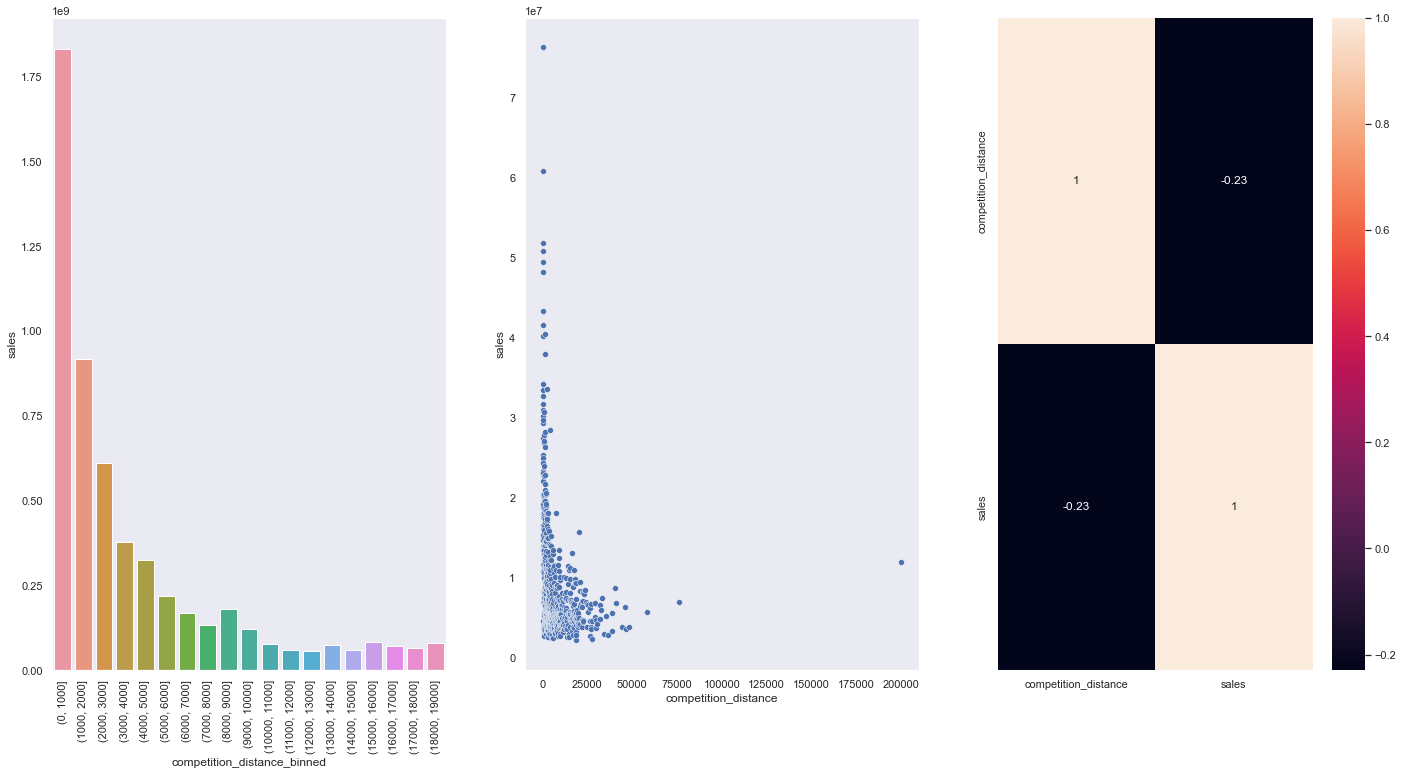

In [29]:
plt.figure(figsize=(24, 12))

plt.subplot(1, 3, 1)
bins = list(np.arange(0, 20000, 1000))
aux1 = df4[['sales', 'competition_distance']].groupby('competition_distance').sum().reset_index()
aux1['competition_distance_binned'] = pd.cut(aux1['competition_distance'], bins=bins)
aux2 = aux1[['sales', 'competition_distance_binned']].groupby('competition_distance_binned').sum().reset_index()
plt.xticks(rotation=90)                                          
sns.barplot(x='competition_distance_binned', y='sales', data=aux2)

plt.subplot(1, 3, 2)
sns.scatterplot(x='competition_distance', y='sales', data=aux1)

plt.subplot(1, 3, 3)
sns.heatmap(aux1.corr(method='pearson'), annot=True);

#### H4. Stores with longer-term competitors should sell more.
**FALSE**. The longer the competition time is, the less it will sell. 

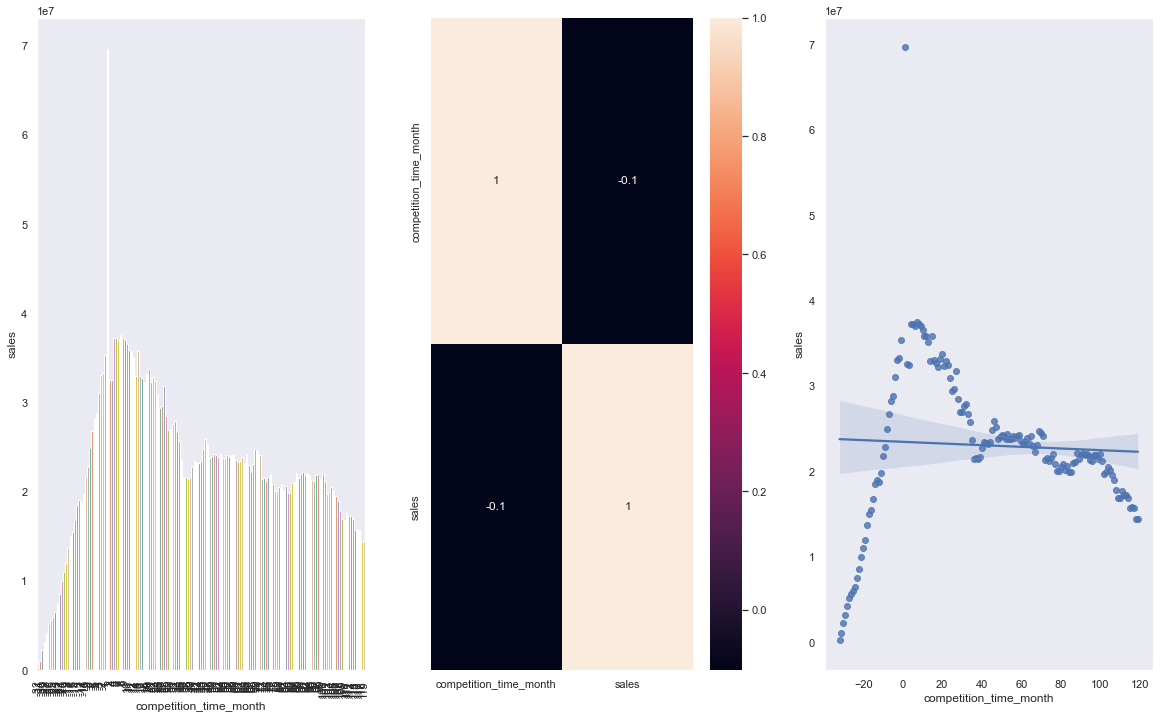

In [30]:
aux1 = df4[['competition_time_month', 'sales']].groupby('competition_time_month').sum().reset_index()
aux2 = aux1[(aux1['competition_time_month'] < 120) & (aux1['competition_time_month'] != 0)]

plt.subplot(1, 3, 1)
sns.barplot(x='competition_time_month', y='sales', data=aux2, palette='Set2')
plt.xticks(rotation=90)


plt.subplot(1, 3, 2)
sns.heatmap(aux1.corr(method='pearson'), annot=True)

plt.subplot(1, 3, 3)
sns.regplot(x='competition_time_month', y='sales', data=aux2);

#### H5. Stores with longer promotions should sell more.
**FALSE**. For a certain amount of time, the sales volume remains the same, and drops after some time.


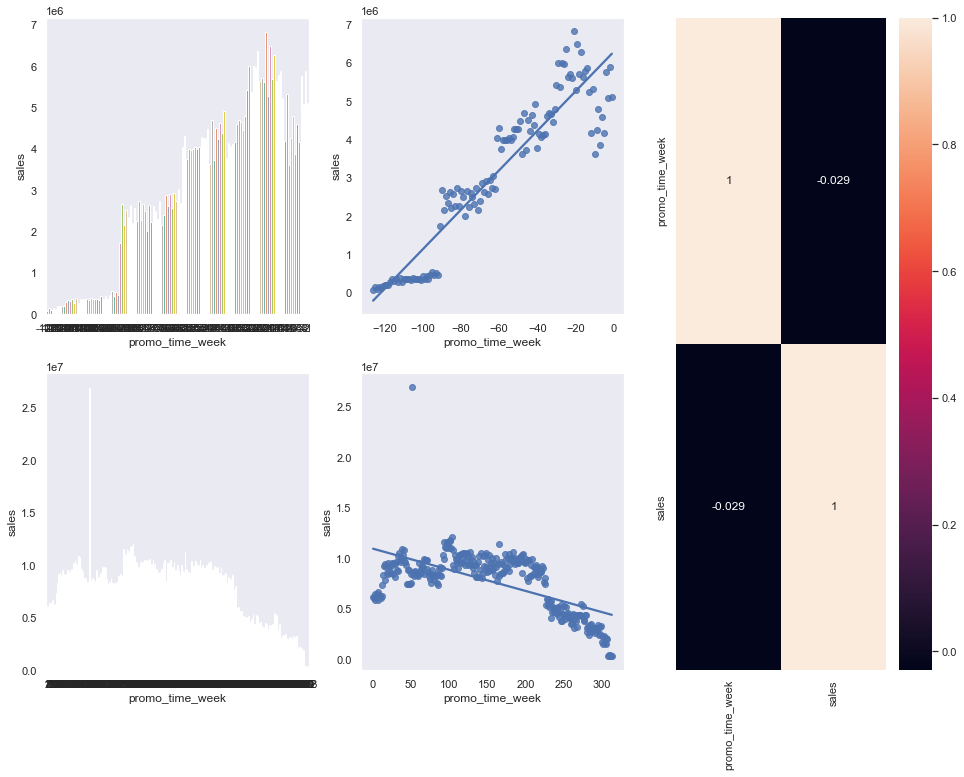

In [31]:
# Create figure
fig = plt.figure(figsize=(16, 12))

# Create grid specs
specs = gridspec.GridSpec(2, 3, figure=fig)

# Add subplot on figure
ax1 = fig.add_subplot(specs[0, 0])
ax2 = fig.add_subplot(specs[0, 1])
ax3 = fig.add_subplot(specs[1, 0])
ax4 = fig.add_subplot(specs[1, 1])
ax5 = fig.add_subplot(specs[:, 2])

# Create DataFrames
aux1 = df4[['sales', 'promo_time_week']].groupby('promo_time_week').sum().reset_index()
aux2 = aux1[aux1['promo_time_week'] < 0]
aux3 = aux1[aux1['promo_time_week'] > 0]

# First plot
sns.barplot(x='promo_time_week', y='sales', data=aux2, ci=None, palette='Set2', ax=ax1)
plt.xticks(rotation=90)

# Second plot
sns.regplot(x='promo_time_week', y='sales', data=aux2, ci=None, ax=ax2)

# Third plot
sns.barplot(x='promo_time_week', y='sales', data=aux3, ci=None, palette='Set2', ax=ax3)
plt.xticks(rotation=90)
 
# Fourth plot
sns.regplot(x='promo_time_week', y='sales', data=aux3, ci=None, ax=ax4)

# Fifth plot
sns.heatmap(aux1.corr(method='pearson'), annot=True, ax=ax5);

#### <s>H6. Stores with more promotion days should sell more.</s>
**On hold:** This hypothesis is similar with hypothesis 5. Therefore, we will take the response of 4 as true and if applicable, in the next cycle, we can return to it.

#### H7. Stores with more consecutive promotions should sell more.
**FALSE**. Data shows that stores with initial promo sales sell more.

In [32]:
aux1 = df4[['sales', 'promo', 'promo2']].groupby(['promo', 'promo2']).sum().reset_index().sort_values(by='sales', ascending=False)

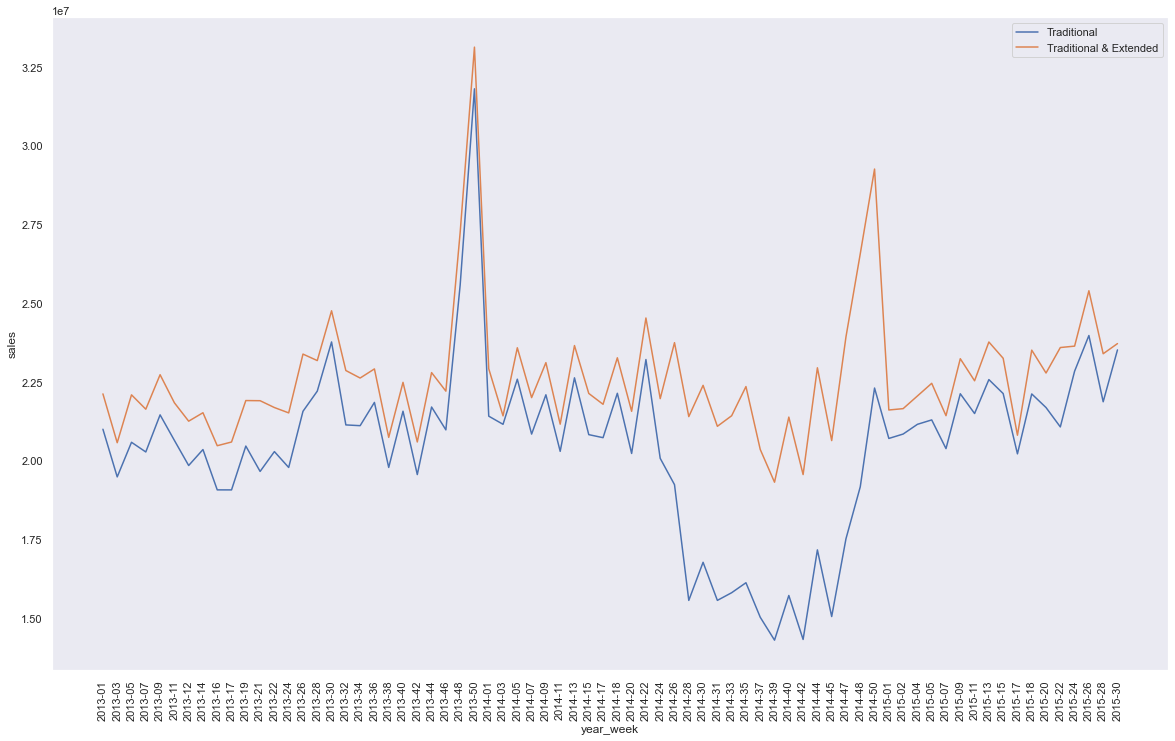

In [33]:
aux1 = df4[(df4['promo'] == 1) & (df4['promo2'] == 1)][['year_week', 'sales']].groupby('year_week').sum().reset_index()
aux2 = df4[(df4['promo'] == 1) & (df4['promo2'] == 0)][['year_week', 'sales']].groupby('year_week').sum().reset_index()

ax1 = sns.lineplot(x='year_week', y='sales', data=aux1)
ax2 = sns.lineplot(x='year_week', y='sales', data=aux2, ax=ax1)

plt.xticks(rotation=90)
ax2.legend(labels=['Traditional', 'Traditional & Extended']);

#### H8. stores open during the Christmas holiday should sell more.
**FALSE**. Christmas holiday presented a small volume of sales.

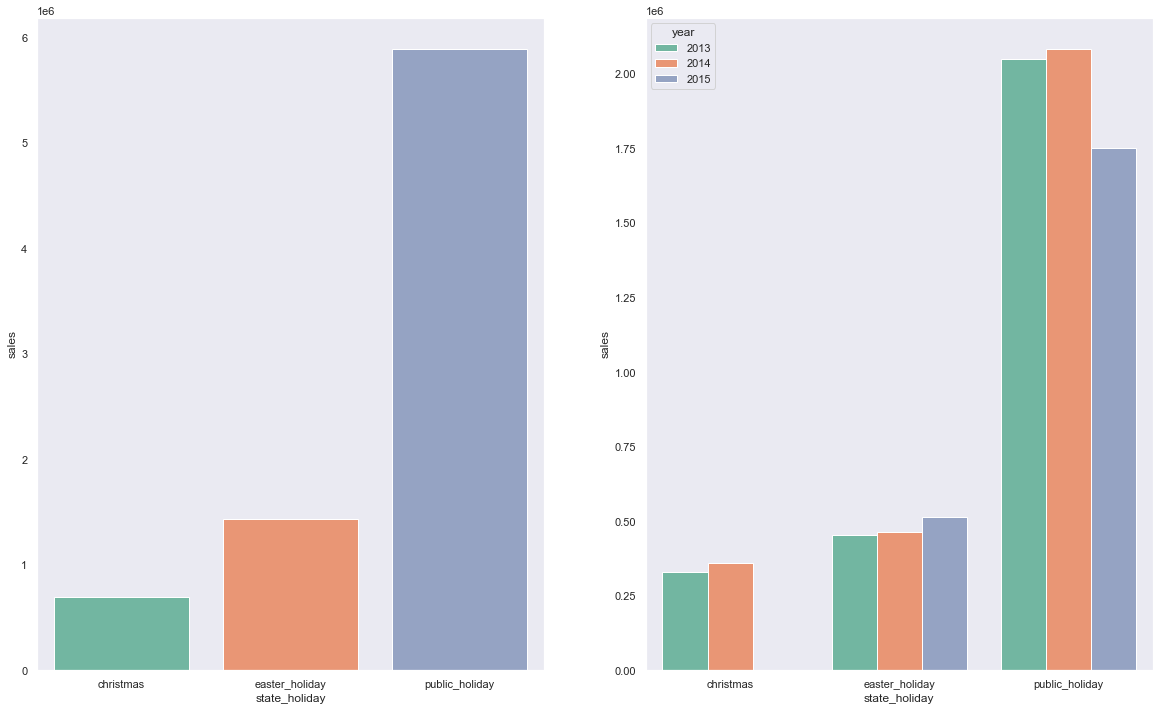

In [34]:
plt.subplot(1, 2, 1)
aux1 = df4[df4['state_holiday'] != 'regular_day'][['sales', 'state_holiday']].groupby('state_holiday').sum().reset_index()
sns.barplot(x='state_holiday', y='sales', data=aux1, palette='Set2')

plt.subplot(1, 2, 2)
aux2 = df4[df4['state_holiday'] != 'regular_day'][['year', 'state_holiday', 'sales']].groupby(['year', 'state_holiday']).sum().reset_index()
sns.barplot(x='state_holiday', y='sales', data=aux2, hue='year', palette='Set2');

#### H9. Stores should sell more over the years.
**TRUE**. 2015 can't be compared because the maximum date is 08/2015, so the sum of the sales it's not a fair metric. When usiing mean or median to group the data, the tendency is that the sales volume is rising.

**By sum**

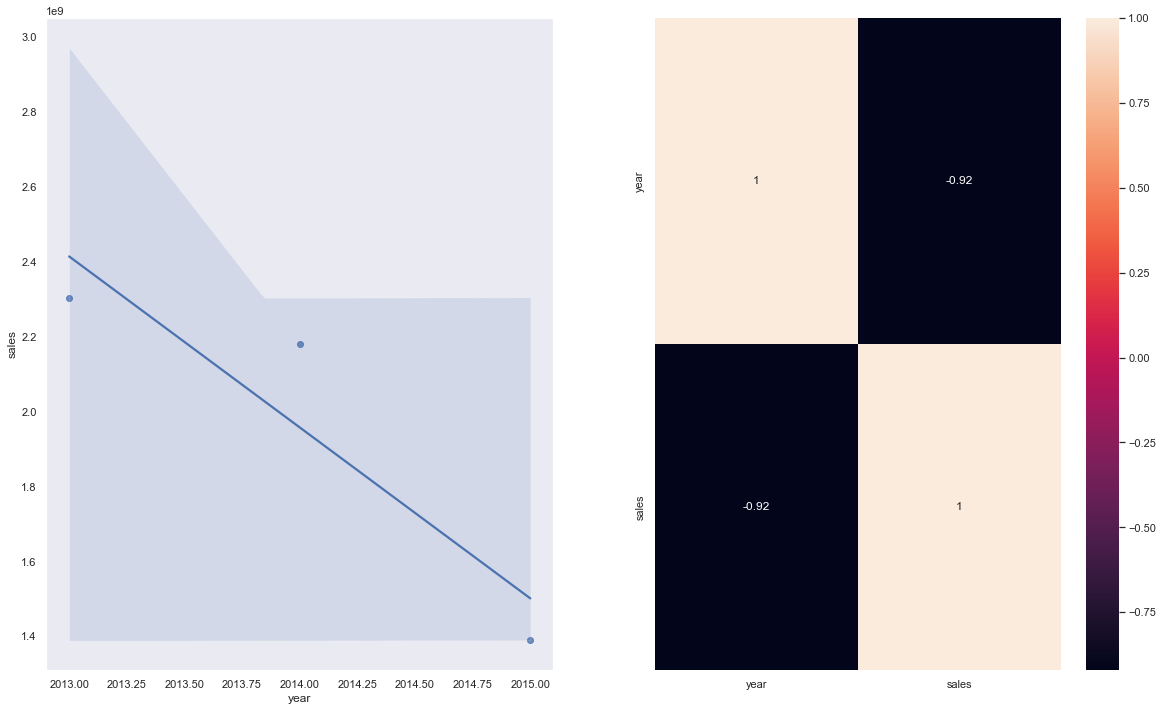

In [35]:
aux1 = df4[['year', 'sales']].groupby('year').sum().reset_index()

plt.subplot(1, 2, 1)
sns.regplot(x='year', y='sales', data=aux1)

plt.subplot(1, 2, 2)
sns.heatmap(aux1.corr(method='pearson'), annot=True);

**By mean**

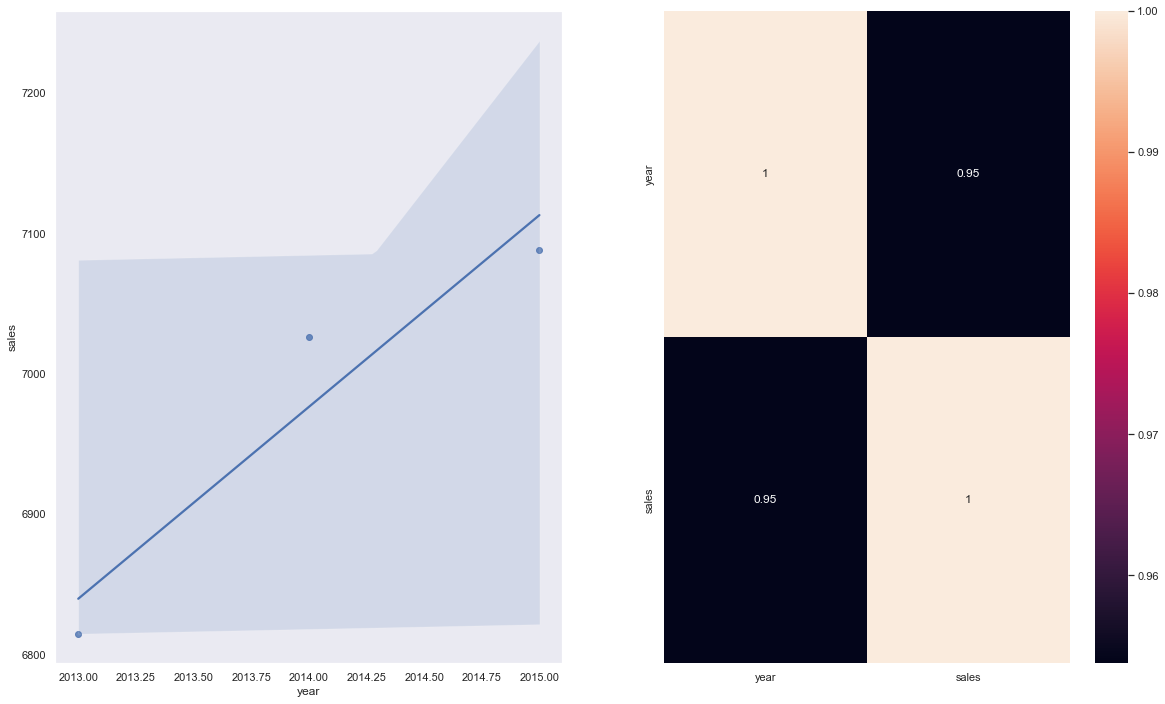

In [36]:
aux1 = df4[['year', 'sales']].groupby('year').mean().reset_index()

plt.subplot(1, 2, 1)
sns.regplot(x='year', y='sales', data=aux1)

plt.subplot(1, 2, 2)
sns.heatmap(aux1.corr(method='pearson'), annot=True);

**By median**

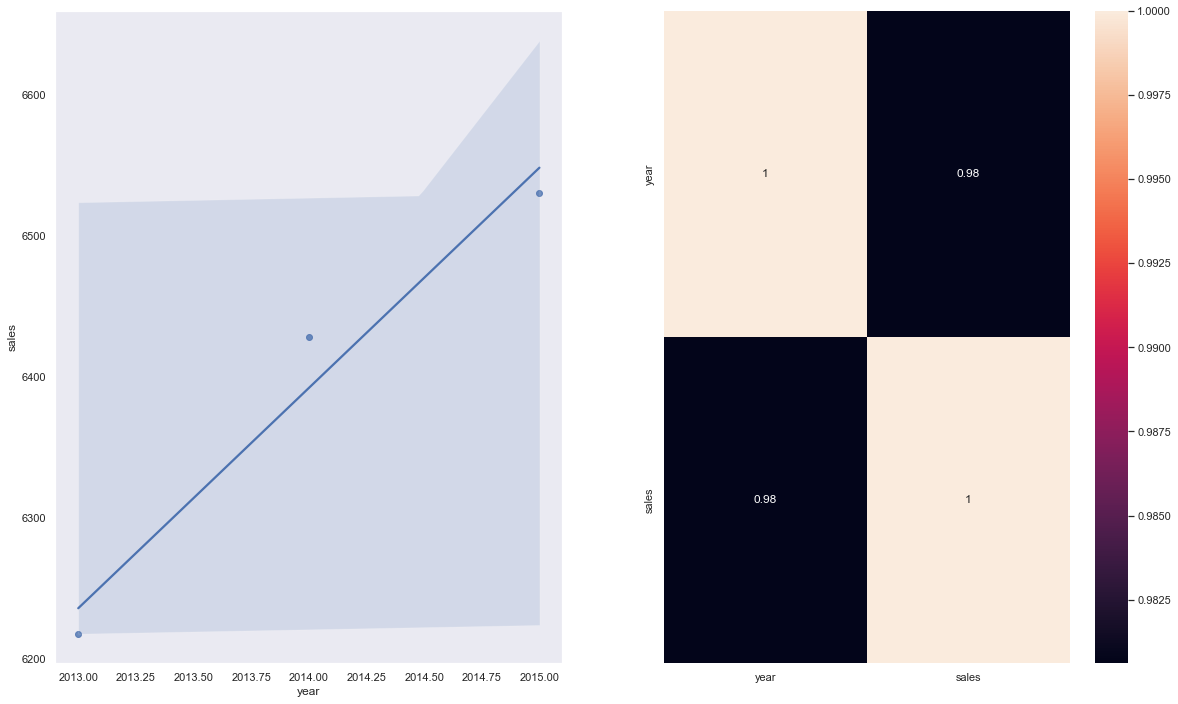

In [37]:
aux1 = df4[['year', 'sales']].groupby('year').median().reset_index()

plt.subplot(1, 2, 1)
sns.regplot(x='year', y='sales', data=aux1)

plt.subplot(1, 2, 2)
sns.heatmap(aux1.corr(method='pearson'), annot=True);

#### H10. Stores should sell more in the second half of the year.
**TRUE**. If I consider the sum, then the sales are more concentrared in the first months of the year. Although, the fact that 2015 is not complete have an affect. So, to round this issue we can call by the mean or the median, and by these metrics, the hypothesis can be validated as true.

**By sum**

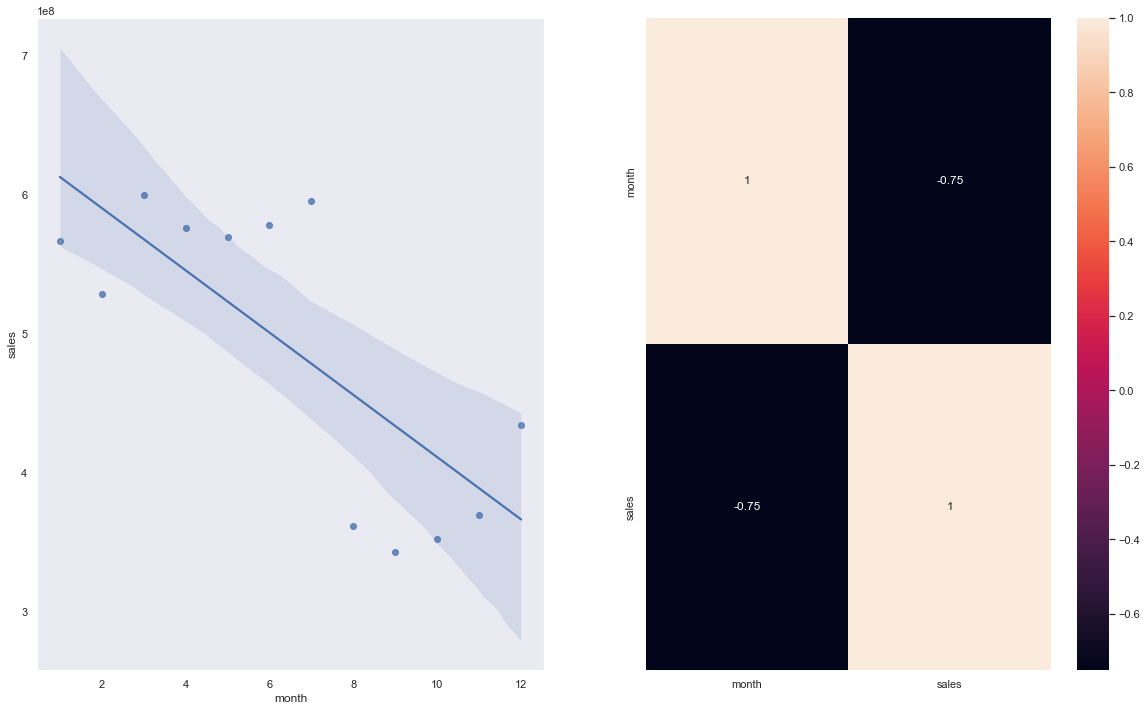

In [38]:
aux1 = df4[['month', 'sales']].groupby('month').sum().reset_index()

plt.subplot(1, 2, 1)
sns.regplot(x='month', y='sales', data=aux1)

plt.subplot(1, 2, 2)
sns.heatmap(aux1.corr(method='pearson'), annot=True);

**By mean**

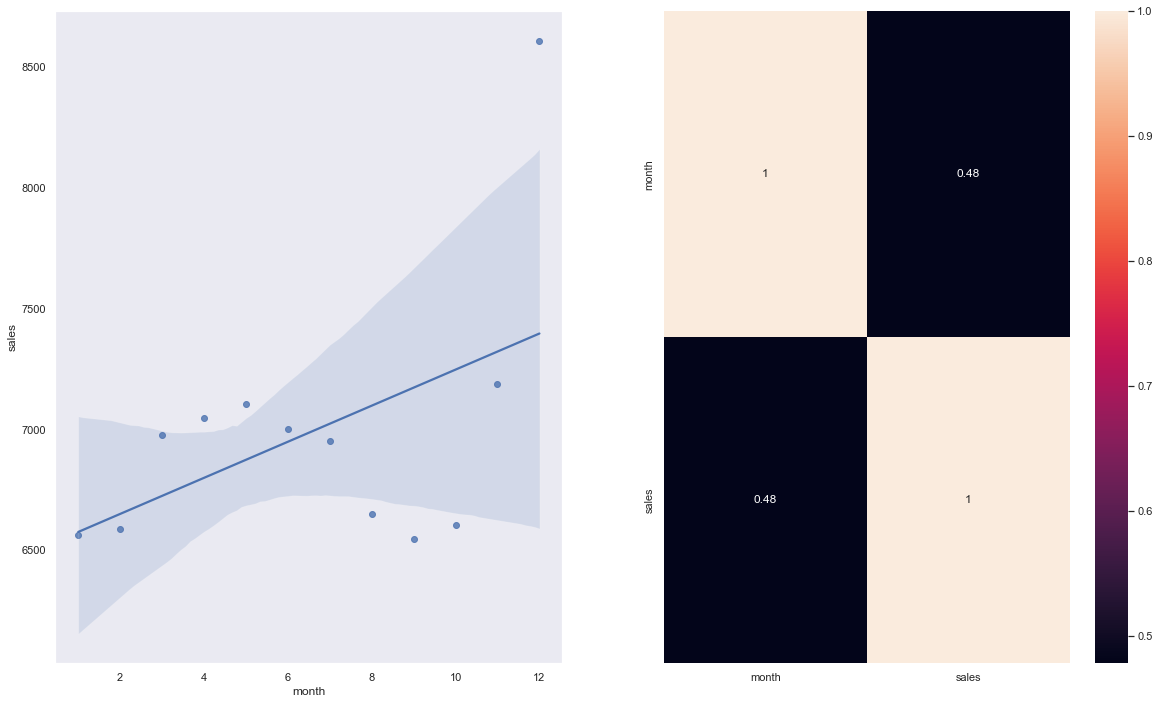

In [39]:
aux1 = df4[['month', 'sales']].groupby('month').mean().reset_index()

plt.subplot(1, 2, 1)
sns.regplot(x='month', y='sales', data=aux1)

plt.subplot(1, 2, 2)
sns.heatmap(aux1.corr(method='pearson'), annot=True);

**By median**

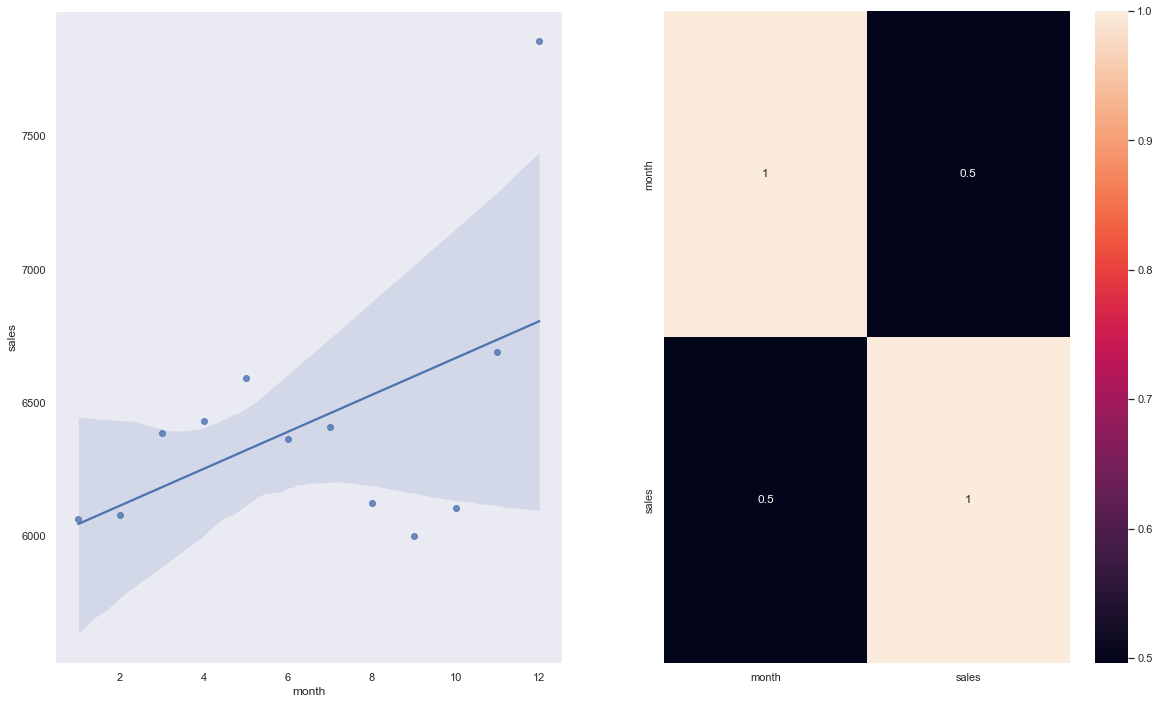

In [40]:
aux1 = df4[['month', 'sales']].groupby('month').median().reset_index()

plt.subplot(1, 2, 1)
sns.regplot(x='month', y='sales', data=aux1)

plt.subplot(1, 2, 2)
sns.heatmap(aux1.corr(method='pearson'), annot=True);

#### H11. Stores should sell more after the 10th day of the month.
**FALSE**. By all metrics, the behavior was the same. The sales volume after the 10th day is much bigger. Although, it is important to know that in the first cluster, we have less days (10/20)

**By Sum**

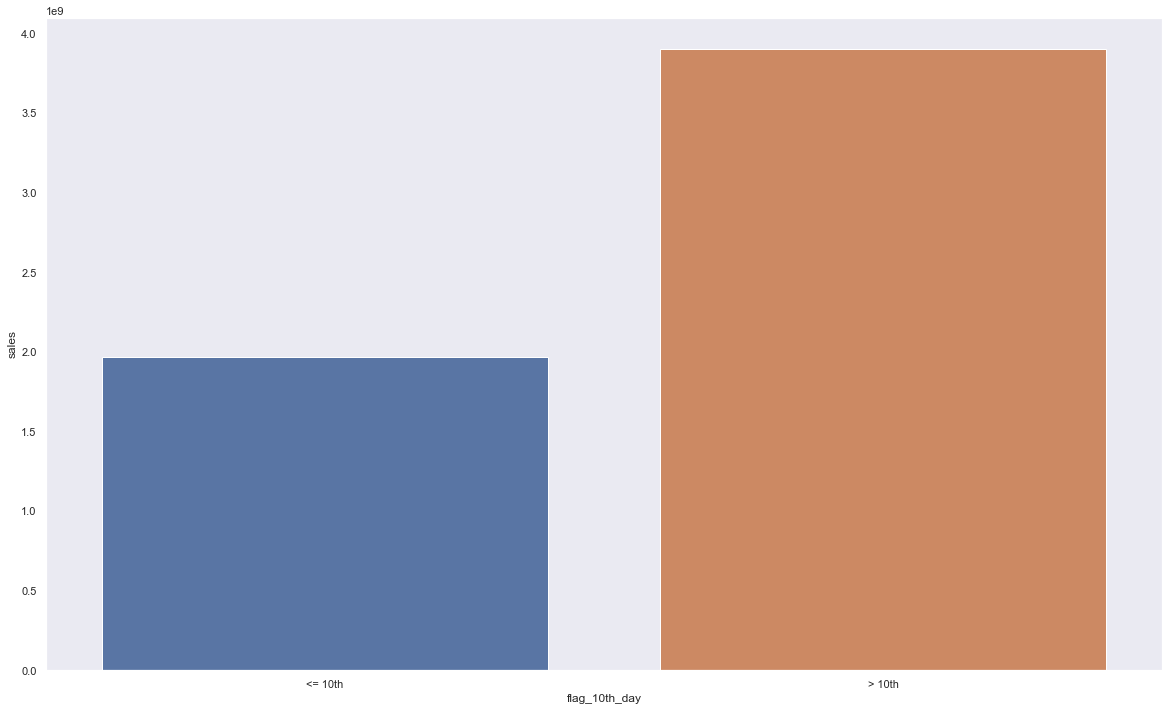

In [41]:
aux1 = df4[['day', 'sales']].groupby('day').sum().reset_index()
aux1['flag_10th_day'] = aux1['day'].apply(lambda x: '<= 10th'if x <= 10 else '> 10th')
aux1 = aux1[['flag_10th_day', 'sales']].groupby('flag_10th_day').sum().reset_index()

sns.barplot(x='flag_10th_day', y='sales', data=aux1);

**By Mean**

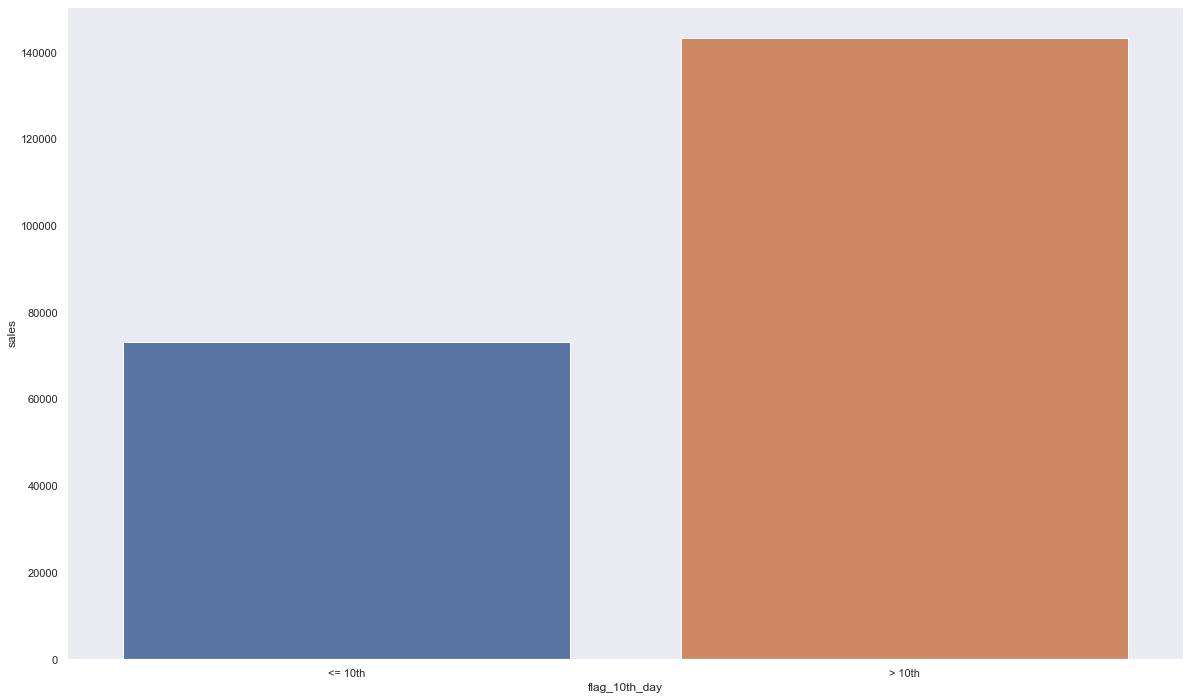

In [42]:
aux1 = df4[['day', 'sales']].groupby('day').mean().reset_index()
aux1['flag_10th_day'] = aux1['day'].apply(lambda x: '<= 10th'if x <= 10 else '> 10th')
aux1 = aux1[['flag_10th_day', 'sales']].groupby('flag_10th_day').sum().reset_index()

sns.barplot(x='flag_10th_day', y='sales', data=aux1);

**By Median**

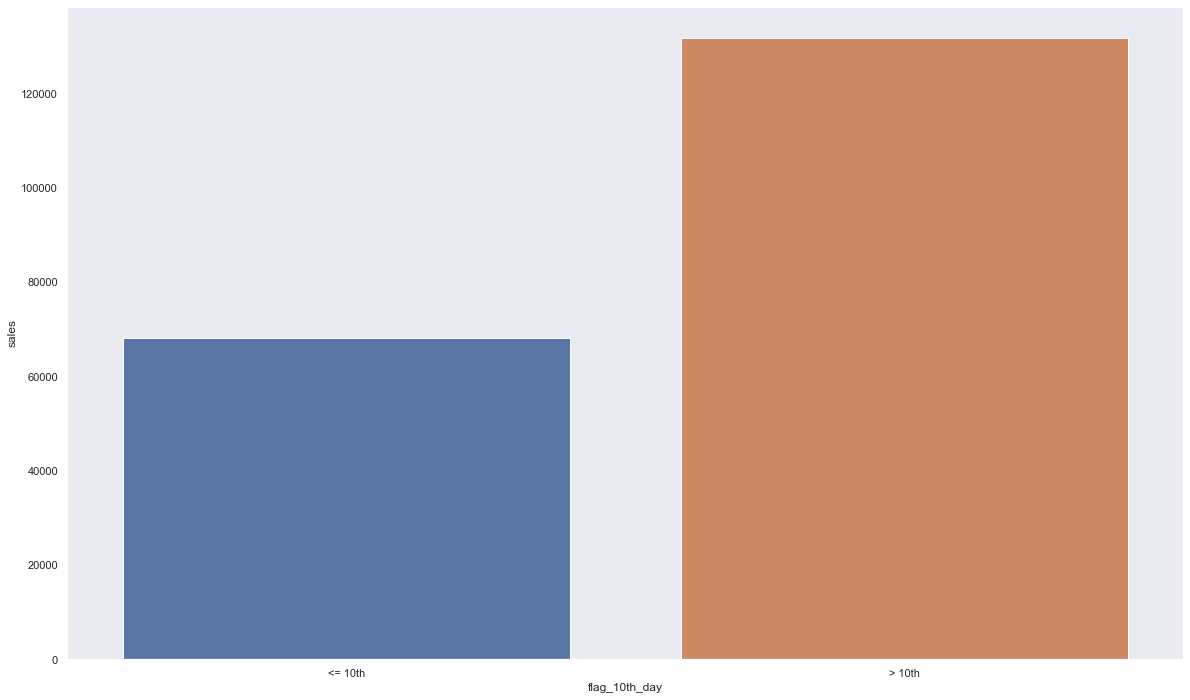

In [43]:
aux1 = df4[['day', 'sales']].groupby('day').median().reset_index()
aux1['flag_10th_day'] = aux1['day'].apply(lambda x: '<= 10th'if x <= 10 else '> 10th')
aux1 = aux1[['flag_10th_day', 'sales']].groupby('flag_10th_day').sum().reset_index()

sns.barplot(x='flag_10th_day', y='sales', data=aux1);

#### H12. Stores should sell less on weekends.
**TRUE**. The higher the day of the week, the lower is the sales volume.

**By Sum**

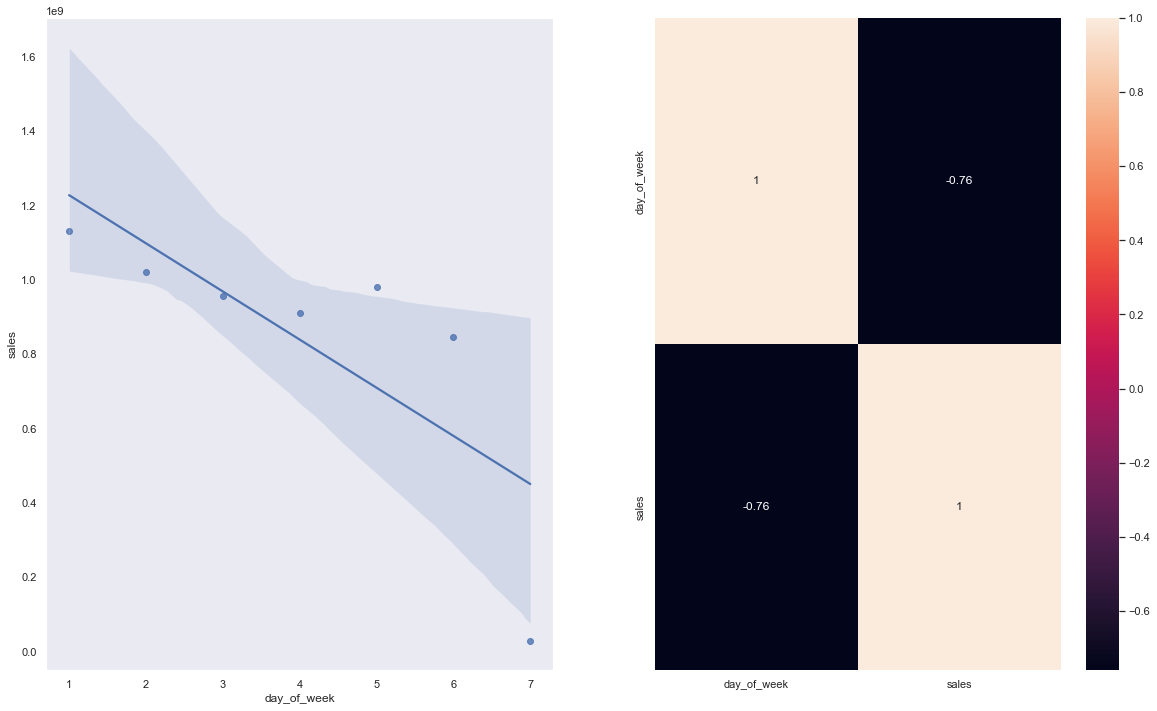

In [47]:
aux1 = df4[['sales', 'day_of_week']].groupby('day_of_week').sum().reset_index()

plt.subplot(1, 2, 1)
sns.regplot(x='day_of_week', y='sales', data=aux1)

plt.subplot(1, 2, 2)
sns.heatmap(aux1.corr(method='pearson'), annot=True);

**By Mean**

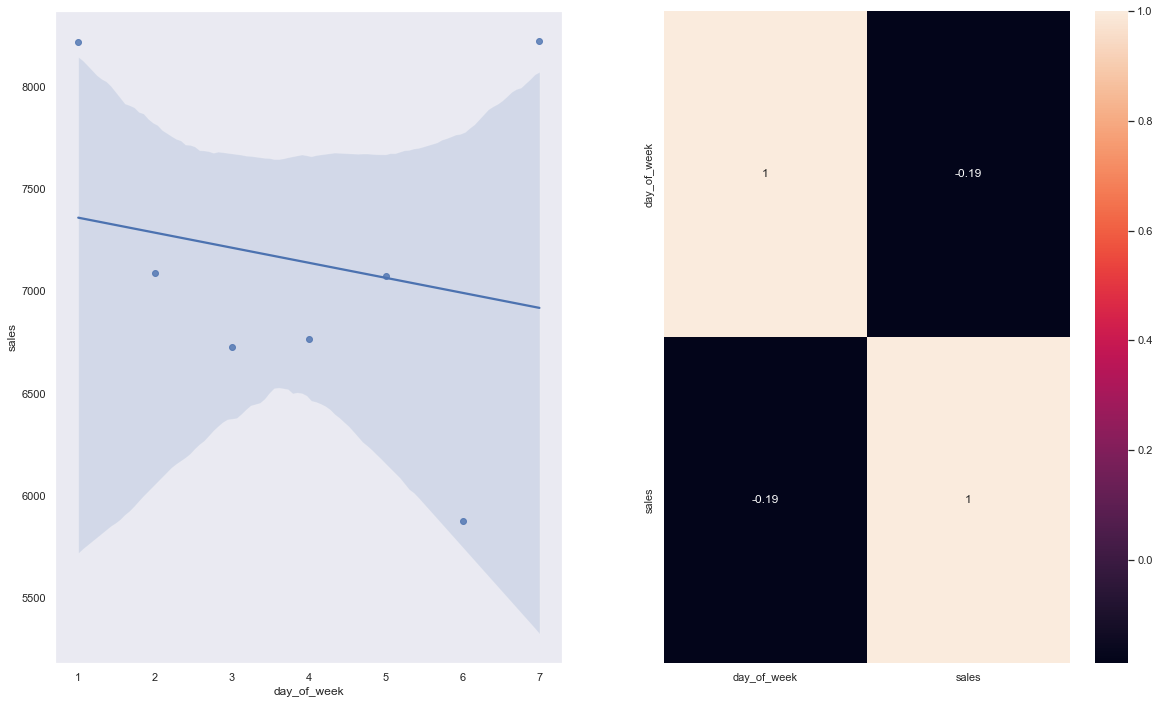

In [48]:
aux1 = df4[['sales', 'day_of_week']].groupby('day_of_week').mean().reset_index()

plt.subplot(1, 2, 1)
sns.regplot(x='day_of_week', y='sales', data=aux1)

plt.subplot(1, 2, 2)
sns.heatmap(aux1.corr(method='pearson'), annot=True);

**By Median**

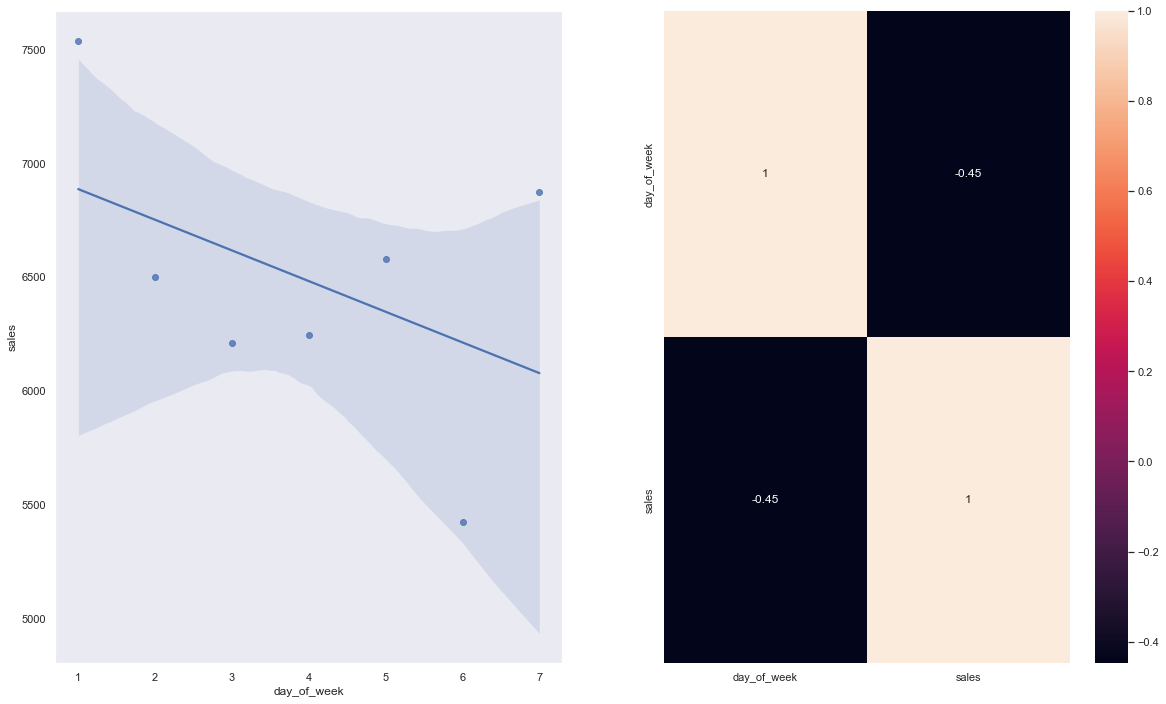

In [49]:
aux1 = df4[['sales', 'day_of_week']].groupby('day_of_week').median().reset_index()

plt.subplot(1, 2, 1)
sns.regplot(x='day_of_week', y='sales', data=aux1)

plt.subplot(1, 2, 2)
sns.heatmap(aux1.corr(method='pearson'), annot=True);

#### H13. Stores should sell less during school holidays.
**FALSE.** When comparing the mean sales volume on school holidays vs regular days or other holidays, the bigger amount is the amount on school holidays.

**By sum**

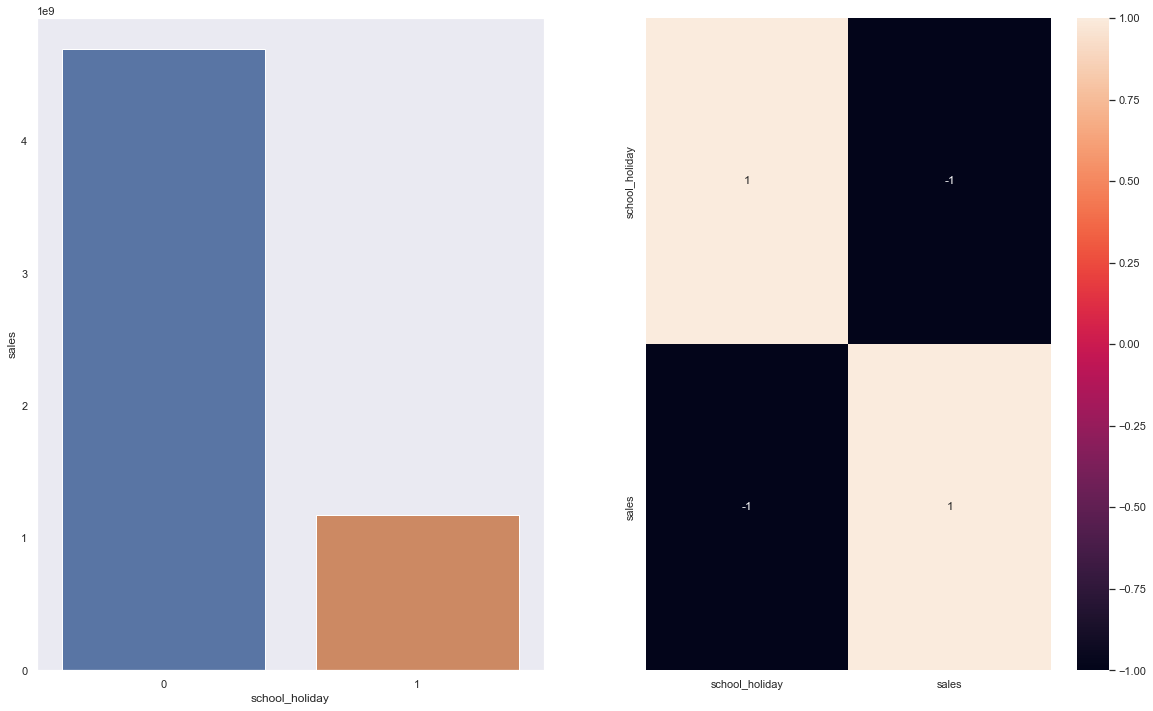

In [51]:
aux1 = df4[['sales', 'school_holiday']].groupby('school_holiday').sum().reset_index()

plt.subplot(1, 2, 1)
sns.barplot(x='school_holiday', y='sales', data=aux1)

plt.subplot(1, 2, 2)
sns.heatmap(aux1.corr(method='pearson'), annot=True);

**By Mean**

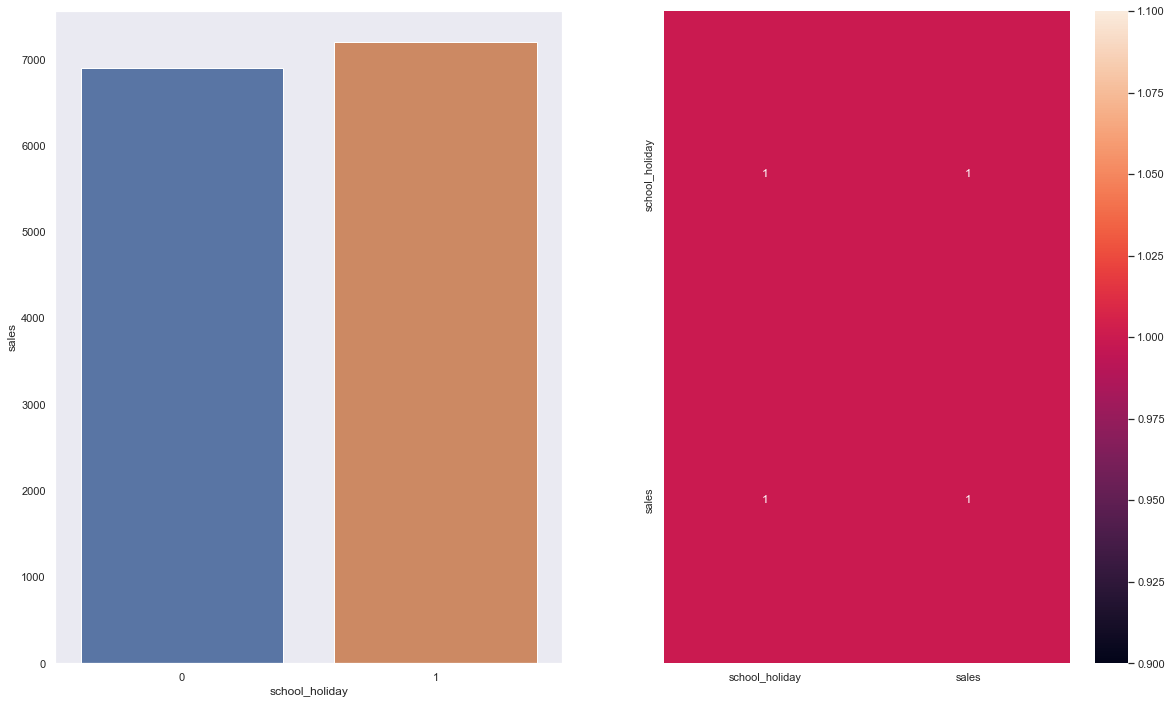

In [52]:
aux1 = df4[['sales', 'school_holiday']].groupby('school_holiday').mean().reset_index()

plt.subplot(1, 2, 1)
sns.barplot(x='school_holiday', y='sales', data=aux1)

plt.subplot(1, 2, 2)
sns.heatmap(aux1.corr(method='pearson'), annot=True);

**By Median**

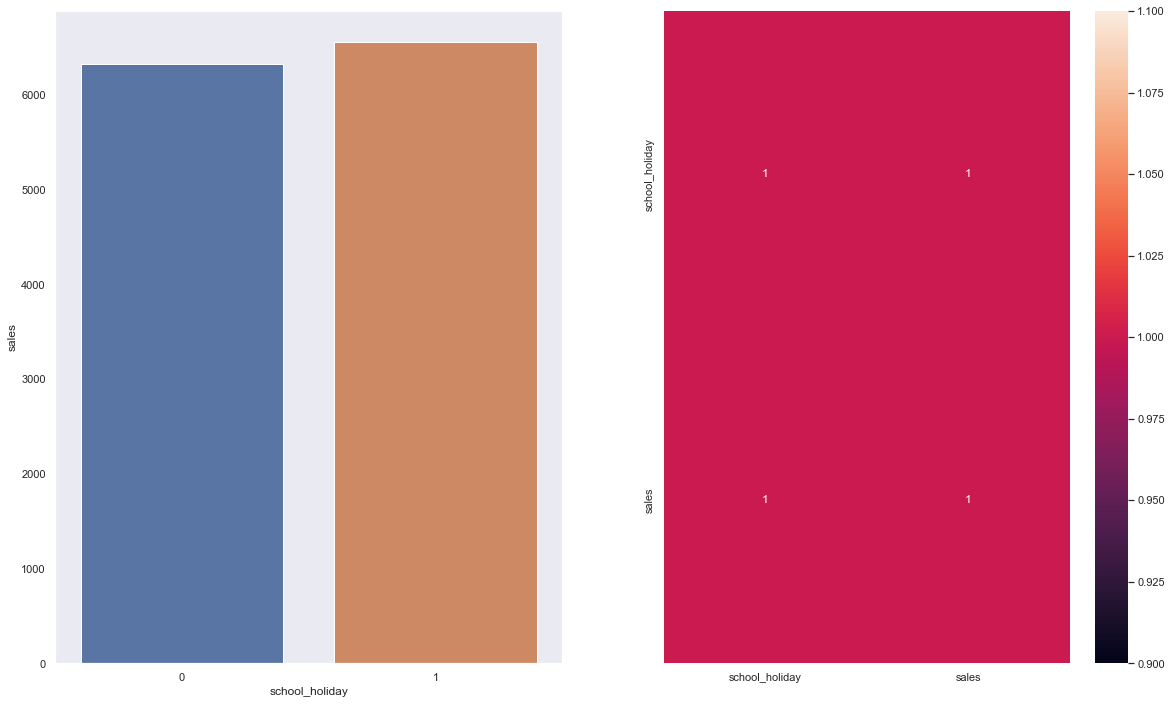

In [53]:
aux1 = df4[['sales', 'school_holiday']].groupby('school_holiday').median().reset_index()

plt.subplot(1, 2, 1)
sns.barplot(x='school_holiday', y='sales', data=aux1)

plt.subplot(1, 2, 2)
sns.heatmap(aux1.corr(method='pearson'), annot=True);

## 4.3 Multivariate